In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Grid Search CV

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/D3/train_data_split.csv')
val_data = pd.read_csv('/content/drive/MyDrive/D3/val_data_split.csv')
test_data = pd.read_csv('/content/drive/MyDrive/D3/test_data_split.csv')

# Prepare the data
vectorizer = TfidfVectorizer(max_features=500)  # Reduced number of features for faster processing
X_train = vectorizer.fit_transform(train_data['text'])
y_train = train_data['label']
X_val = vectorizer.transform(val_data['text'])
y_val = val_data['label']
X_test = vectorizer.transform(test_data['text'])
y_test = test_data['label']

# Set up the Random Forest model and hyperparameters
rf = RandomForestClassifier()
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]  # Added an additional parameter for better tuning
}

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                    n_iter=20, cv=3, n_jobs=-1, verbose=2,
                                    random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and model
best_rf = random_search.best_estimator_

# Evaluate the model on the validation set
y_pred_val = best_rf.predict(X_val)
print("Validation Set Performance:\n", classification_report(y_val, y_pred_val))

# Evaluate the model on the test set
y_pred_test = best_rf.predict(X_test)
print("Test Set Performance:\n", classification_report(y_test, y_pred_test))

# Save the best model and vectorizer
model_save_path = '/content/drive/MyDrive/D3/D3_Random/grid_rf_model.pkl'
joblib.dump(best_rf, model_save_path)
joblib.dump(vectorizer, '/content/drive/MyDrive/D3/D3_Random/tfidf_vectorizer.pkl')

# Save the predictions for ensembling later
test_data['rf_predictions'] = y_pred_test
test_data.to_csv('/content/drive/MyDrive/D3/D3_Random/test_data_with_rf_predictions.csv', index=False)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Validation Set Performance:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1189
           1       0.94      0.96      0.95      1188

    accuracy                           0.95      2377
   macro avg       0.95      0.95      0.95      2377
weighted avg       0.95      0.95      0.95      2377

Test Set Performance:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1189
           1       0.94      0.96      0.95      1189

    accuracy                           0.95      2378
   macro avg       0.95      0.95      0.95      2378
weighted avg       0.95      0.95      0.95      2378



# Bayes Optimiaztion

In [ ]:
!pip install scikit-optimize

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Integer
from joblib import dump

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/val.csv')
test_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/test.csv')

# Assume 'label' is the target and other columns are features
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_val = val_data.drop(columns=['label'])
y_val = val_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Combine training and validation data
X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])

# Preprocessing pipeline
numeric_features = X_train_combined.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_combined.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Handle unknown categories during testing
    ])

# Define the Random Forest model and hyperparameter space
rf_model = RandomForestClassifier(random_state=42)
param_space = {
    'classifier__n_estimators': Integer(100, 300),
    'classifier__max_depth': Integer(10, 30),
    'classifier__min_samples_split': Integer(2, 10),
    'classifier__min_samples_leaf': Integer(1, 4)
}

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', rf_model)])

# Initialize Bayesian Optimization
bayes_search = BayesSearchCV(estimator=pipeline, search_spaces=param_space, n_iter=30, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the model
bayes_search.fit(X_train_combined, y_train_combined)

# Save the best model
model_save_path = '/content/drive/MyDrive/D3/D3_Random/bayes_rf_model.pkl'
dump(bayes_search.best_estimator_, model_save_path)

# Evaluate the best model on the test set
y_pred = bayes_search.best_estimator_.predict(X_test) # No need to replace unknown categories now
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

# PBT

In [ ]:
!pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from joblib import dump

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/val.csv')
test_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/test.csv')

# Assume 'label' is the target and other columns are features
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_val = val_data.drop(columns=['label'])
y_val = val_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Combine training and validation data
X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])

# Preprocessing pipeline
numeric_features = X_train_combined.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_combined.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the model pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_combined)

# Get the best performing model
best_model = grid_search.best_estimator_

# Fit the best model on the combined training and validation set
best_model.fit(X_train_combined, y_train_combined)

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Save the best model
model_save_path = '/content/drive/MyDrive/D3/D3_Random/pbt_rf_model.pkl'
dump(best_model, model_save_path)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Test Accuracy: 0.655599603567889


['/content/drive/MyDrive/D3/D3_Random/pbt_rf_model.pkl']

# Genetic

In [ ]:
pip install scikit-learn deap

In [ ]:
pip install deap scikit-learn pandas

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from deap import base, creator, tools, algorithms
import random
import pickle

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/val.csv')
test_data = pd.read_csv('/content/drive/MyDrive/D3/dataset/test.csv')

# Assuming 'title' is the text feature and 'label' is the target column
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
val_data['label'] = label_encoder.transform(val_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_text = vectorizer.fit_transform(train_data['title'])
X_val_text = vectorizer.transform(val_data['title'])
X_test_text = vectorizer.transform(test_data['title'])

# Separate features and target
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

# Define the evaluation function
def evaluate(individual):
    n_estimators, max_depth, min_samples_split, min_samples_leaf = individual
    # Ensure parameters are within valid ranges
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    if min_samples_leaf < 1:
        min_samples_leaf = 1

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth if max_depth > 0 else None,  # max_depth can be None
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    model.fit(X_train_text, y_train)
    predictions = model.predict(X_val_text)
    accuracy = accuracy_score(y_val, predictions)
    return (accuracy,)

# Set up the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_n_estimators", random.randint, 50, 200)  # n_estimators between 50 and 200
toolbox.register("attr_max_depth", random.randint, 1, 20)  # max_depth between 1 and 20
toolbox.register("attr_min_samples_split", random.randint, 2, 20)  # min_samples_split between 2 and 20
toolbox.register("attr_min_samples_leaf", random.randint, 1, 20)  # min_samples_leaf between 1 and 20

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators, toolbox.attr_max_depth,
                  toolbox.attr_min_samples_split, toolbox.attr_min_samples_leaf),
                 n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[50, 1, 2, 1], up=[200, 20, 20, 20], eta=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create population and run the algorithm
population = toolbox.population(n=10)
NGEN, CXPB, MUTPB = 10, 0.5, 0.2

print("Starting Genetic Algorithm...")
algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, verbose=True)

# Get the best individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best individual: {best_individual}")
print(f"Best fitness: {best_individual.fitness.values[0]}")

# Train the Random Forest with the best parameters and evaluate on test set
best_model = RandomForestClassifier(
    n_estimators=int(best_individual[0]),
    max_depth=int(best_individual[1]) if best_individual[1] > 0 else None,
    min_samples_split=int(best_individual[2]),
    min_samples_leaf=int(best_individual[3])
)
best_model.fit(X_train_text, y_train)
y_test_pred = best_model.predict(X_test_text)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Random Forest): {test_accuracy:.4f}")

target_names = [str(cls) for cls in label_encoder.classes_]
print("\nClassification Report on Test Set (Random Forest):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Save the model
model_save_path = '/content/drive/MyDrive/D3/D3_Random/genetic_rf_model.pkl'
with open(model_save_path, 'wb') as model_file:
    pickle.dump(best_model, model_file)

print(f"Model saved to {model_save_path}")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Starting Genetic Algorithm...
gen	nevals
0  	10    
1  	6     
2  	4     
3  	7     
4  	7     
5  	6     
6  	7     
7  	2     
8  	6     
9  	6     
10 	5     
Best individual: [133.27592032166018, 17.552871299632447, 10.217156193346494, 15.588369011219896]
Best fitness: 0.8959365708622399
Test Accuracy (Random Forest): 0.8459

Classification Report on Test Set (Random Forest):
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       822
           1       0.79      1.00      0.88      1196

    accuracy                           0.85      2018
   macro avg       0.89      0.81      0.83      2018
weighted avg       0.88      0.85      0.84      2018

Model saved to /content/drive/MyDrive/D3/D3_Random/genetic_rf_model.pkl


# BERT + GSCV

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ensemble Test Set Performance:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1189
           1       0.94      0.96      0.95      1189

    accuracy                           0.95      2378
   macro avg       0.95      0.95      0.95      2378
weighted avg       0.95      0.95      0.95      2378

Confusion Matrix:
 [[1112   77]
 [  48 1141]]


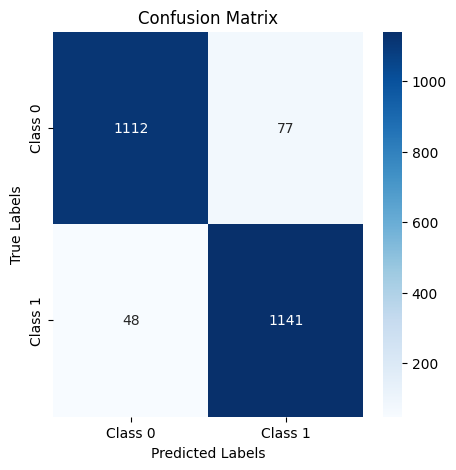

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt

# Load data and models
test_data_path = '/content/drive/MyDrive/D3/D3_Random/test_data_with_rf_predictions.csv'
rf_model_path = '/content/drive/MyDrive/D3/D3_Random/grid_rf_model.pkl'
vectorizer_path = '/content/drive/MyDrive/D3/D3_Random/tfidf_vectorizer.pkl'
bert_model_path = '/content/drive/MyDrive/D3/bert_model.pth'

test_data = pd.read_csv(test_data_path)
best_rf = joblib.load(rf_model_path)
vectorizer = joblib.load(vectorizer_path)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
bert_model.load_state_dict(torch.load(bert_model_path))
bert_model.eval()

# Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return text, label
        return text

def encode_batch(batch, tokenizer, max_length=512):
    return tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

def get_bert_predictions(model, tokenizer, dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    predictions = []

    for batch in dataloader:
        texts = batch if isinstance(batch, list) else batch[0]
        inputs = encode_batch(texts, tokenizer)
        with torch.no_grad():
            outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
        predictions.extend(preds)

    return predictions

# Process test data
test_texts = test_data['text'].tolist()
test_dataset = TextDataset(test_texts)
bert_test_predictions = get_bert_predictions(bert_model, tokenizer, test_dataset)

# Ensure predictions are integer type
test_data['bert_predictions'] = pd.Series(bert_test_predictions).astype(int)

# Weighted voting
rf_weight = 0.6
bert_weight = 0.4
test_data['ensemble_predictions'] = test_data.apply(lambda x: 1 if (x['rf_predictions'] * rf_weight + x['bert_predictions'] * bert_weight) >= 0.5 else 0, axis=1)

# Evaluation
print("Ensemble Test Set Performance:\n", classification_report(test_data['label'], test_data['ensemble_predictions']))

# Confusion matrix
conf_matrix = confusion_matrix(test_data['label'], test_data['ensemble_predictions'])
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the ensemble predictions
output_path = '/content/drive/MyDrive/D3/D3_Random/test_data_with_ensemble_predictions.csv'
test_data.to_csv(output_path, index=False)


# Testing with Sampling

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ensemble Subset Performance:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       520
           1       0.94      0.96      0.95       480

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix:
 [[491  29]
 [ 17 463]]


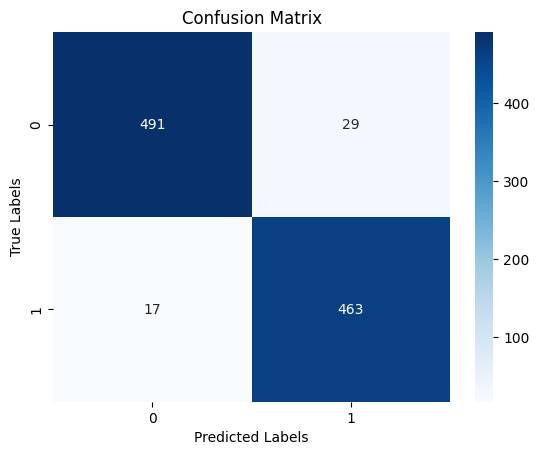

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Load test data with Random Forest predictions
test_data = pd.read_csv('/content/drive/MyDrive/D3/D3_Random/test_data_with_rf_predictions.csv')

# Load the Random Forest model and vectorizer
rf_model_path = '/content/drive/MyDrive/D3/D3_Random/grid_rf_model.pkl'
vectorizer_path = '/content/drive/MyDrive/D3/D3_Random/tfidf_vectorizer.pkl'
best_rf = joblib.load(rf_model_path)
vectorizer = joblib.load(vectorizer_path)

# Load the BERT model and tokenizer
bert_model_path = '/content/drive/MyDrive/D3/bert_model.pth'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
bert_model.load_state_dict(torch.load(bert_model_path))

# Prepare the data for BERT
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return text, label
        return text

def encode_batch(batch, tokenizer, max_length=512):
    return tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

def get_bert_predictions(model, tokenizer, dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    predictions = []

    for batch in dataloader:
        texts = batch if isinstance(batch, list) else batch[0]
        inputs = encode_batch(texts, tokenizer)
        with torch.no_grad():
            outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
        predictions.extend(preds)

    return predictions

# Subset sampling
subset_data = test_data.sample(n=1000, random_state=42)  # Sample 1000 instances

# Prepare datasets
subset_texts = subset_data['text'].tolist()
subset_dataset = TextDataset(subset_texts)

# Get BERT predictions for subset data with batch processing
bert_subset_predictions = get_bert_predictions(bert_model, tokenizer, subset_dataset)

# Ensemble predictions (weighted voting example)
subset_data['bert_predictions'] = bert_subset_predictions
subset_data['ensemble_predictions'] = subset_data.apply(
    lambda x: 1 if (0.7 * x['rf_predictions'] + 0.3 * x['bert_predictions']) > 0.5 else 0, axis=1)

# Evaluate ensemble performance on the subset
print("Ensemble Subset Performance:\n", classification_report(subset_data['label'], subset_data['ensemble_predictions']))

# Confusion matrix
conf_matrix = confusion_matrix(subset_data['label'], subset_data['ensemble_predictions'])
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the ensemble predictions for the subset
subset_data.to_csv('/content/drive/MyDrive/D3/D3_Random/subset_test_data_with_ensemble_predictions.csv', index=False)